In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]/10**4-b[i]/10**4)#/(a[i]+b[i])*10**4
    return bas

In [3]:
lob_data=utils.caricaLOB('bynd',0.05)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change().fillna(0).copy()
b=pd.DataFrame(baSpread(lob_data),columns=['spread'])


In [4]:
spread=b['spread'].to_numpy()
d=np.log(b).diff().fillna(0).to_numpy().flatten()
hot=np.zeros(len(d))
for i in range(0,len(hot)):
    if spread[i]<=0.05: #spread[i]-spread[i-1]>0.03:
        hot[i]=1 #se spread[i]>soglia up
    else: #-spread[i-1]<0.02:
        hot[i]=0 #se spread[i]<soglia lo
#plt.plot(hot);

In [29]:
np.quantile(spread,0.9), np.quantile(spread,0.1), stats.mode(b)

(0.15000000000000568, 0.030000000000001137)

In [6]:
hot,spread

(array([1., 1., 0., ..., 0., 0., 0.]),
 array([0.05, 0.05, 0.1 , ..., 0.11, 0.07, 0.11]))

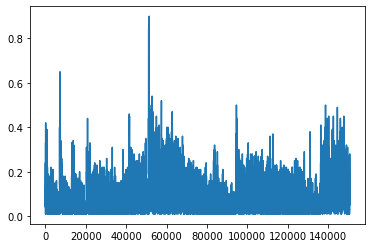

In [7]:
plt.plot(spread)

CNN-LSTM Classifier
===

In [8]:
def prepare_x_y(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6,1)

    Y = np_utils.to_categorical(y.astype(int),2)

    return X,Y

In [9]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX,trainY = prepare_x_y  (n_train)    
valiX ,valiY  = prepare_x_y  (n_vali )    
testX ,testY  = prepare_x_y  (n_test )   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(90368, 100, 6, 1) (90368, 2)
(30056, 100, 6, 1) (30056, 2)
(30056, 100, 6, 1) (30056, 2)


In [10]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(2, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [11]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [12]:
#deeplob.load_weights('modelMSFTClassification.h5')
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])

Epoch 1/50
353/353 [==============================] - 161s 451ms/step - loss: 0.6609 - accuracy: 0.6119 - val_loss: 0.6514 - val_accuracy: 0.6523
Epoch 2/50
353/353 [==============================] - 142s 401ms/step - loss: 0.6341 - accuracy: 0.6383 - val_loss: 0.6552 - val_accuracy: 0.6525
Epoch 3/50
353/353 [==============================] - 142s 402ms/step - loss: 0.6254 - accuracy: 0.6476 - val_loss: 0.6497 - val_accuracy: 0.6568
Epoch 4/50
353/353 [==============================] - 144s 408ms/step - loss: 0.6140 - accuracy: 0.6586 - val_loss: 0.6473 - val_accuracy: 0.6562
Epoch 5/50
353/353 [==============================] - 140s 397ms/step - loss: 0.5987 - accuracy: 0.6751 - val_loss: 0.6484 - val_accuracy: 0.6571
Epoch 6/50
353/353 [==============================] - 141s 398ms/step - loss: 0.5860 - accuracy: 0.6865 - val_loss: 0.6565 - val_accuracy: 0.6601
Epoch 7/50
353/353 [==============================] - 139s 394ms/step - loss: 0.5753 - accuracy: 0.6960 - val_loss: 0.6382 -

In [30]:
#deeplob.save('modelBYNDClassification.h5')


In [13]:
P = deeplob.predict(testX)
pj= np.round(P)
P

940/940 [==============================] - 24s 25ms/step


array([[0.563621  , 0.43637896],
       [0.5356764 , 0.4643236 ],
       [0.5765701 , 0.4234299 ],
       ...,
       [0.92397225, 0.07602777],
       [0.94726396, 0.05273598],
       [0.8799893 , 0.1200107 ]], dtype=float32)

In [14]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(pj, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pj, axis=1), digits=4))

accuracy_score: 0.7031873835507053
              precision    recall  f1-score   support

           0     0.7618    0.8293    0.7941     20749
           1     0.5258    0.4219    0.4682      9307

    accuracy                         0.7032     30056
   macro avg     0.6438    0.6256    0.6312     30056
weighted avg     0.6887    0.7032    0.6932     30056



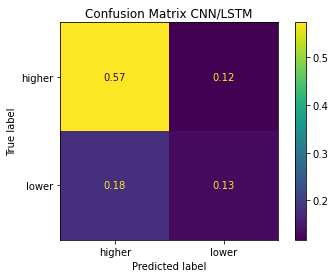

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

LSTM classifier
===

In [16]:
def prepare_x_y_lstm(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6)

    Y = np_utils.to_categorical(y.astype(int),2)

    return X,Y

In [17]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX_lstm,trainY_lstm = prepare_x_y_lstm  (n_train)    
valiX_lstm,valiY_lstm = prepare_x_y_lstm  (n_vali )    
testX_lstm,testY_lstm = prepare_x_y_lstm  (n_test )   


print(trainX_lstm.shape ,trainY_lstm .shape)
print(valiX_lstm.shape  ,valiY_lstm .shape)
print(testX_lstm.shape  ,testY_lstm .shape)

(90368, 100, 6) (90368, 2)
(30056, 100, 6) (30056, 2)
(30056, 100, 6) (30056, 2)


In [18]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.001)
loss_function = 'categorical_crossentropy'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function, metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           18176     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100, 64)           0   

In [19]:
#model.load_weights('classifyLSTM.h5')
lstmMSFT=model.fit(trainX_lstm, trainY_lstm, validation_data=(valiX_lstm, valiY_lstm), epochs=20, batch_size=256)

Epoch 1/20
353/353 [==============================] - 218s 605ms/step - loss: 0.6367 - accuracy: 0.6340 - val_loss: 0.6677 - val_accuracy: 0.6364
Epoch 2/20
353/353 [==============================] - 256s 725ms/step - loss: 0.5881 - accuracy: 0.6823 - val_loss: 0.6742 - val_accuracy: 0.6287
Epoch 3/20
353/353 [==============================] - 253s 717ms/step - loss: 0.5545 - accuracy: 0.7116 - val_loss: 0.7084 - val_accuracy: 0.6129
Epoch 4/20
353/353 [==============================] - 250s 708ms/step - loss: 0.5279 - accuracy: 0.7325 - val_loss: 0.7228 - val_accuracy: 0.5857
Epoch 5/20
353/353 [==============================] - 249s 705ms/step - loss: 0.5078 - accuracy: 0.7483 - val_loss: 0.7677 - val_accuracy: 0.5787
Epoch 6/20
353/353 [==============================] - 301s 853ms/step - loss: 0.4944 - accuracy: 0.7551 - val_loss: 0.7343 - val_accuracy: 0.6220
Epoch 7/20
353/353 [==============================] - 276s 781ms/step - loss: 0.4819 - accuracy: 0.7644 - val_loss: 0.7612 -

In [31]:
#model.save('lstmBYNDClassification.h5')

In [21]:
P_lstm = model.predict(testX_lstm)
p_lstmj= np.round(P_lstm)
P_lstm

940/940 [==============================] - 47s 49ms/step


array([[0.19377826, 0.8062217 ],
       [0.340583  , 0.65941703],
       [0.08326833, 0.91673166],
       ...,
       [0.9901518 , 0.00984814],
       [0.89397186, 0.1060282 ],
       [0.9621297 , 0.03787023]], dtype=float32)

In [22]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1)))
print(classification_report(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1), digits=4))

accuracy_score: 0.6518166089965398
              precision    recall  f1-score   support

           0     0.7340    0.7772    0.7550     20749
           1     0.4284    0.3722    0.3983      9307

    accuracy                         0.6518     30056
   macro avg     0.5812    0.5747    0.5767     30056
weighted avg     0.6394    0.6518    0.6446     30056



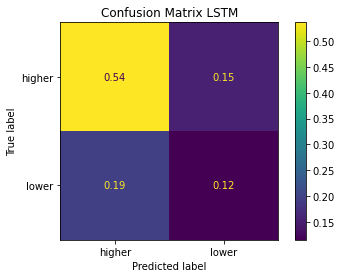

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix LSTM");

Naive Gaussian Classifier
===

In [24]:
rng = np.random.RandomState(1)
X = n_train[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
y = n_train['h'].to_numpy()
Xte = n_vali[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
Yte = n_vali['h'].to_numpy()#['h'].to_numpy()
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB()
clf.fit(X, y)
predNB = clf.predict(Xte)
encPr=np_utils.to_categorical(predNB)
#encTe=np_utils.to_categorical(Yte)
print(predNB,Yte)

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 1. 1. 1.]


In [25]:
encTe=np_utils.to_categorical(n_vali['h'].to_numpy())

In [26]:
print('accuracy_score:', accuracy_score(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1)))
print(classification_report(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1), digits=4))

accuracy_score: 0.37249635230136624
              precision    recall  f1-score   support

           0     0.6247    0.0408    0.0765     19236
           1     0.3615    0.9569    0.5248     10920

    accuracy                         0.3725     30156
   macro avg     0.4931    0.4988    0.3007     30156
weighted avg     0.5294    0.3725    0.2389     30156



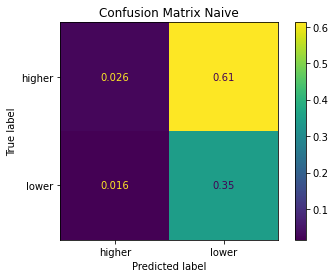

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix Naive");

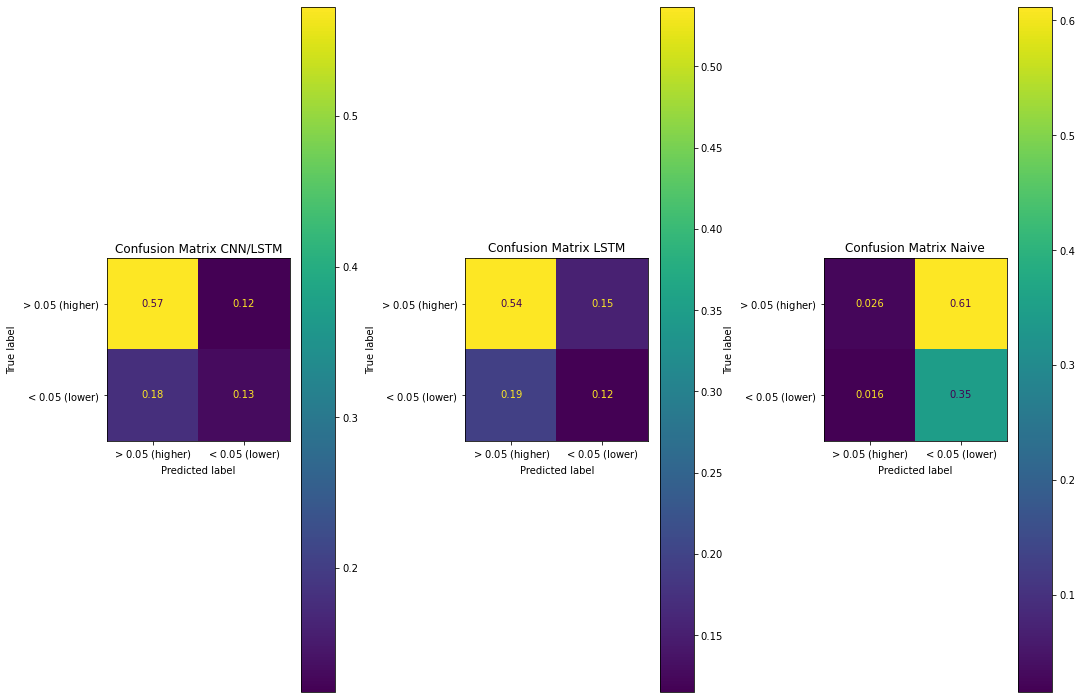

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive")
plt.tight_layout()  ;

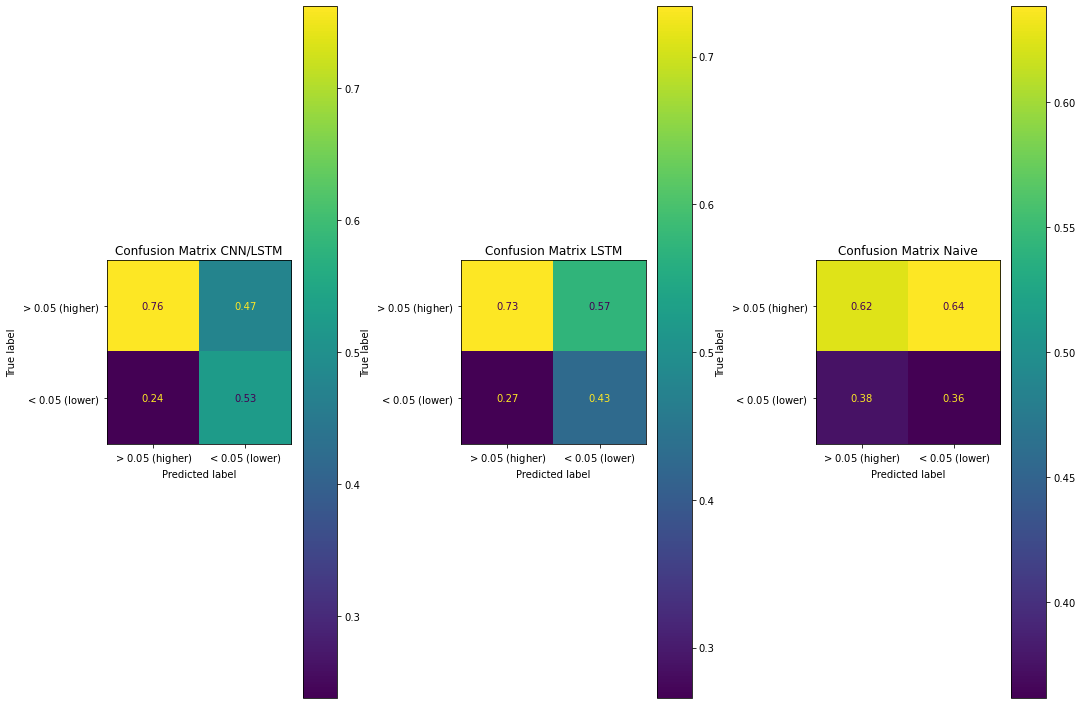

In [36]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive")
plt.tight_layout()  ;

1) Precision is a measure of how many of the positive predictions made are correct (true positives).
2) Accuracy describes the number of correct predictions over all predictions (TP+TN)/sizePop.
3) Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
4) F1 provides a single metric that weights the two ratios (precision and recall) in a balanced way.
    - Very small precision or recall will result in lower overall score. Thus it helps balance the two metrics.
    - If you choose your positive class as the one with fewer samples, F1-score can help balance the metric across positive/negative samples.